# Temporal Saliency Rescaling (TSR)
Temporal Saliency Rescaling (TSR), developed by Ismail et al. (2020) [1], is built upon known saliency methods such as GradCam [2] or Shap [3]. Their benchmark study shows that traditional saliency methods fail to reliably and accurately identify feature importances due to the time and feature domain. TSR is proposed on top of the traditional saliency methods as a two-step approach for improving the quality of saliency maps. The importance of each time step is calculated, followed by the feature importance. 

The code in TSInterpret is based on the authors <a href='https://github.com/ayaabdelsalam91/TS-Interpretability-Benchmark'>implementation </a>.

[1] Aya Abdelsalam Ismail, Mohamed Gunady, Héctor Corrada Bravo, and Soheil Feizi. Benchmarking Deep Learning Interpretability in Time Series Predictions. arXiv:2010.13924 [cs, stat], October 2020. arXiv: 2010.13924. 

[2] R. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh, and D. Batra. Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization. Int J Comput Vis, 128(2):336–359, Feb. 2020. ISSN 0920-5691, 1573-1405. doi: 10.1007/s11263-019-01228-7. arXiv: 1610.02391.

[3] S. M. Lundberg and S.-I. Lee. A Unified Approach to Interpreting Model Predictions. In I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, and R.Garnett, editors, Advances in Neural Information Processing Systems 30, pages 4765–4774. Curran Associates, Inc., 2017.

In [1]:
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import pandas as pd
import os 
from tslearn.datasets import UCR_UEA_datasets
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import sklearn
import matplotlib as plt
import seaborn as sns

/home/jacqueline/.local/share/virtualenvs/TSInterpret-x4eqnPOt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
dataset='Epilepsy'

In [3]:
UCR_UEA_datasets().list_multivariate_datasets()

['ArticularyWordRecognition',
 'AtrialFibrillation',
 'BasicMotions',
 'CharacterTrajectories',
 'Cricket',
 'DuckDuckGeese',
 'EigenWorms',
 'Epilepsy',
 'EthanolConcentration',
 'ERing',
 'FaceDetection',
 'FingerMovements',
 'HandMovementDirection',
 'Handwriting',
 'Heartbeat',
 'InsectWingbeat',
 'JapaneseVowels',
 'Libras',
 'LSST',
 'MotorImagery',
 'NATOPS',
 'PenDigits',
 'PEMS-SF',
 'Phoneme',
 'RacketSports',
 'SelfRegulationSCP1',
 'SelfRegulationSCP2',
 'SpokenArabicDigits',
 'StandWalkJump',
 'UWaveGestureLibrary']

# Load Data

Load Data and reshape the data to fit a 1D-Conv ResNet. 
Note that the input for a 1D-Conv Resnet hat the shape (batch, features, timesteps).

In [4]:
X_train,y_train, X_test, y_test=UCR_UEA_datasets().load_dataset(dataset)
train_x=np.swapaxes(X_train,1,2)#.reshape(-1,X_train.shape[-1],X_train.shape[-2])
train_x=np.nan_to_num(train_x)
test_x=np.swapaxes(X_test,1,2)#X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=np.nan_to_num(test_x)
train_y = y_train
test_y=y_test


In [5]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
pickle.dump(enc1,open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))    

/home/jacqueline/.local/share/virtualenvs/TSInterpret-x4eqnPOt/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Model Training
Trains a ResNet and saves the results.

In [6]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=X_train.shape[-1], num_pred_classes=n_pred_classes)
#model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
fit(model,train_loader,test_loader)
if dataset in os.listdir('../../ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'../../ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'../../ClassificationModels/models/{dataset}/ResNet')
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
test_preds, ground_truth = get_all_preds(model, test_loader)

model.eval()

Epoch: 1, Train loss: 0.762, Val loss: 1.043
Epoch: 2, Train loss: 0.552, Val loss: 0.392
Epoch: 3, Train loss: 0.442, Val loss: 0.275
Epoch: 4, Train loss: 0.627, Val loss: 0.399
Epoch: 5, Train loss: 0.361, Val loss: 0.34
Epoch: 6, Train loss: 0.188, Val loss: 0.222
Epoch: 7, Train loss: 0.143, Val loss: 0.148
Epoch: 8, Train loss: 0.054, Val loss: 0.197
Epoch: 9, Train loss: 0.039, Val loss: 0.161
Epoch: 10, Train loss: 0.017, Val loss: 0.145
Epoch: 11, Train loss: 0.023, Val loss: 0.123
Epoch: 12, Train loss: 0.019, Val loss: 0.155
Epoch: 13, Train loss: 0.006, Val loss: 0.177
Epoch: 14, Train loss: 0.004, Val loss: 0.181
Epoch: 15, Train loss: 0.003, Val loss: 0.176
Epoch: 16, Train loss: 0.003, Val loss: 0.171
Epoch: 17, Train loss: 0.002, Val loss: 0.163
Epoch: 18, Train loss: 0.002, Val loss: 0.163
Epoch: 19, Train loss: 0.001, Val loss: 0.164
Epoch: 20, Train loss: 0.001, Val loss: 0.166
Epoch: 21, Train loss: 0.001, Val loss: 0.171
Epoch: 22, Train loss: 0.001, Val loss: 0.17

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(3, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(3, 64, kernel_size=(1,)

# Interpretability Algorithm

Using a interpretability algorithm consists of 4 steps: 

1. Load the Interpretability Method
2. Instaniate the Method with the desired Parameters
3. Call the explain Method
4. Plot the results

## 2. Initialization 
The TSR works on gradient-based models. Currently support for TensorFlow (TF) and PYTorch (PYT) is available. For PYT the Subclass `Saliency_PTY` is used, while TF expects the use of `Saliency_TF`.
The Initialization takes the following arguments:

- `model`: The model to be explaines. 
- `NumTimeStep`: Number of Time Step.
- `NumFetaures`: Number Features.
- `method`: Saliency Methode to be used.

      * Gradients (GRAD)
      * Integrated Gradients (IG)
      * Gradient Shap (GS)
      * DeepLift (DL)
      * DeepLiftShap (DLS)
      * SmoothGrad (SG)
      * Shapley Value Sampling(SVS)
      * Feature Permutation (FP)
      * Feature Sampling (FS)
      * Occlusion (FO)
      
      
- `mode`: Second dimension 'time' or 'feat'.

In [7]:
from TSInterpret.InterpretabilityModels.Saliency.TSR import TSR
int_mod=TSR(model, train_x.shape[-1],train_x.shape[-2], method='GS', \
    mode='feat')

2023-09-18 14:02:29.017433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 14:02:29.790998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 3. Call the explain method. 
Prepeare the instance and the predicted label of the instance as parameters for the explain methods. 

- `item`: item to be explained
- `labels`: predicted label for the item as class. 
- `TSR`: Turns temporal rescaling on / off.

In [8]:
item = np.array([train_x[1,:,:]])
label =test_preds[1]

In [13]:
exp=int_mod.explain(item,labels=label,TSR =False)

In [10]:
exp.shape

(3, 206)

## 4. Visualization 
All plot function take as input the item to be explained and the returned explanation. As as additonal option a figsize can be given.
For visualizing saliency there are two visualization options provided:
1. On Sample 
2. Heatmap

NOT Time mode


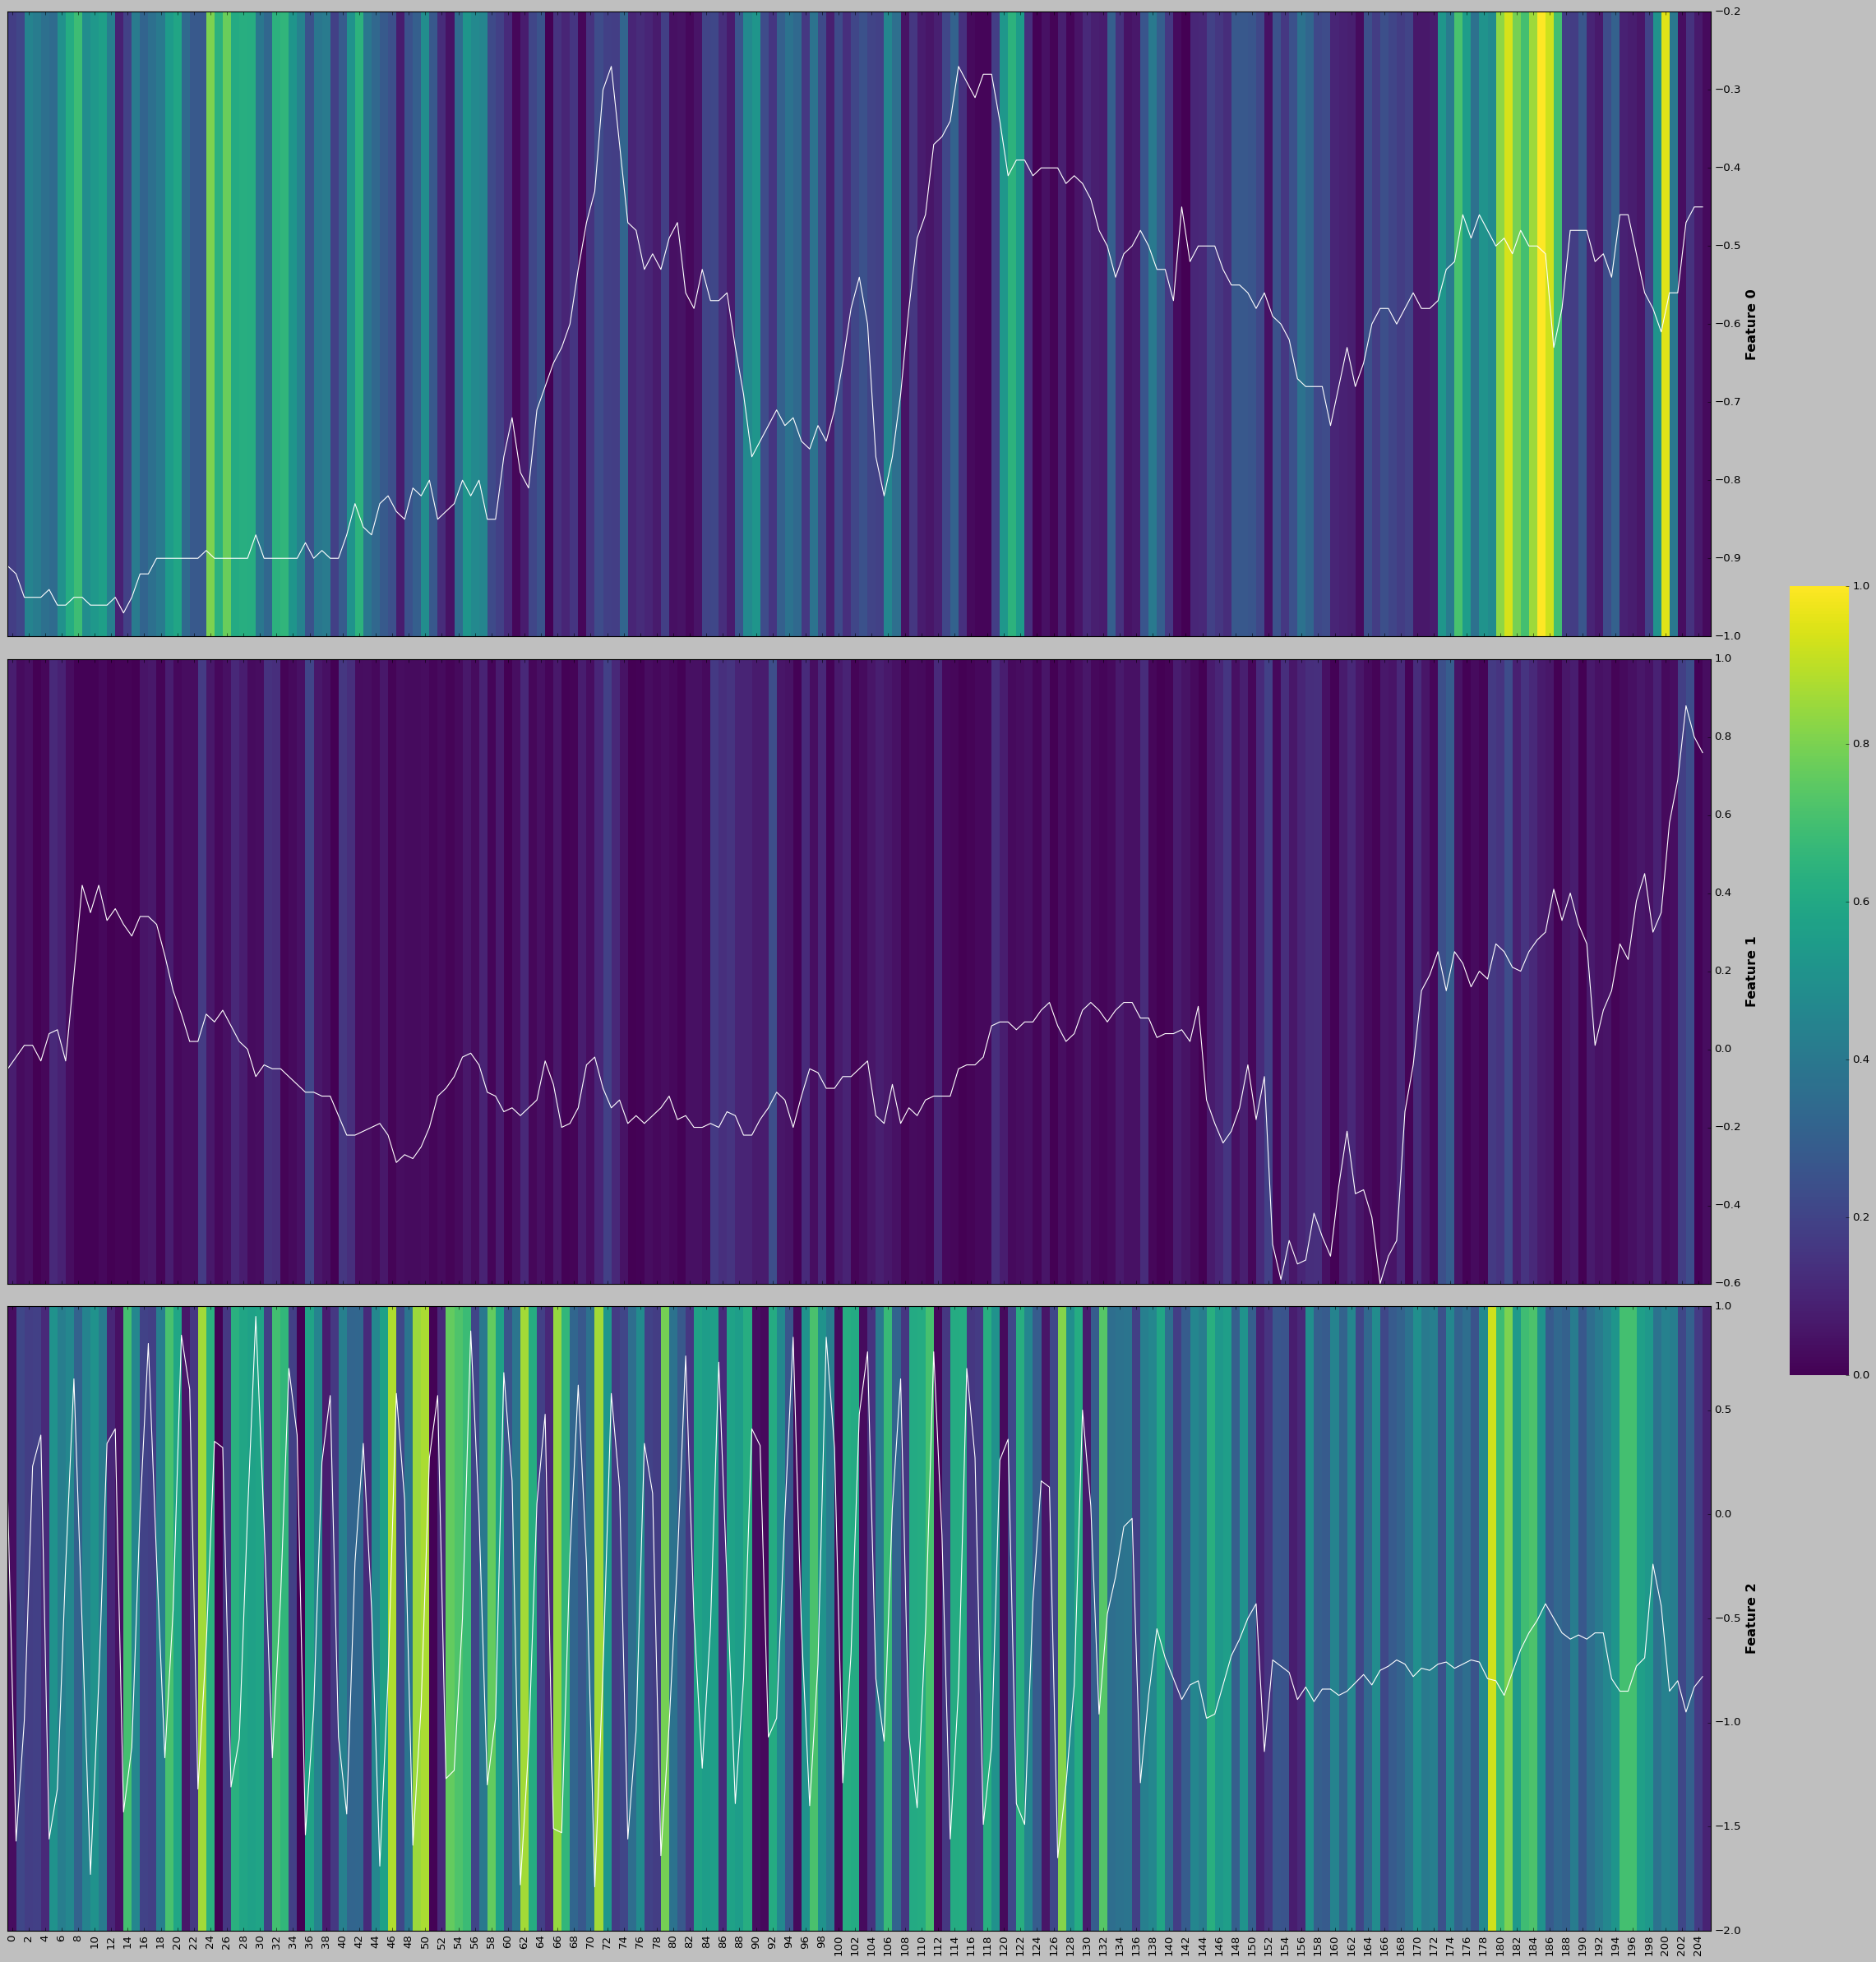

In [14]:
int_mod.plot(np.array(item),exp, figsize=(30,30), save='Ismail_Ep.png')

NOT Time mode


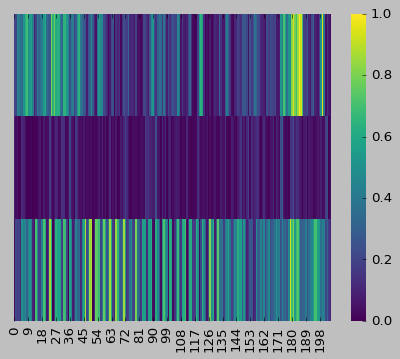

In [15]:
int_mod.plot(np.array([test_x[0,:,:]]),exp, heatmap = True)

Additional Examples, e.g. for the use with LSTM or TF can be found <a href='https://github.com/JHoelli/TSInterpret/tree/main/docs/Notebooks'>here</a>.